# `Gabor` Filter

In [1]:
from skimage.filters import gabor_kernel, gabor
from skimage import io

from matplotlib import pyplot as plt 
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

## Display image

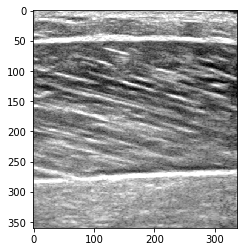

In [2]:
im = io.imread('data/bmc1.bmp')
plt.imshow(im);

## Apply `gabor` filter

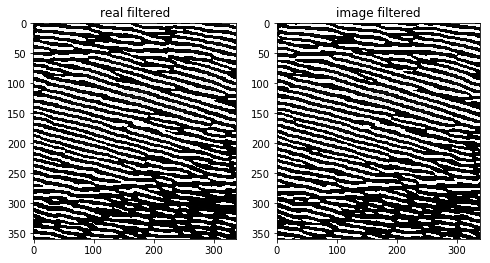

In [3]:
# filt_real, filt_imag = gabor(im, frequency=0.7, theta=0.2)  
filt_real, filt_imag = gabor(im, frequency=0.1, theta=1.8, bandwidth=0.7)
plt.figure('gabor',figsize=(8,8))

plt.subplot(121)
plt.title('real filtered')
plt.imshow(filt_real);  

plt.subplot(122)
plt.title('image filtered')
plt.imshow(filt_imag);

## Visualize filter

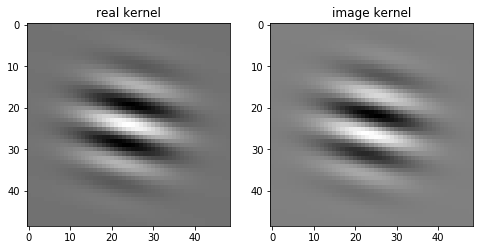

In [4]:
gk = gabor_kernel(frequency=0.1, theta=1.8, bandwidth=0.7)     
plt.figure('gabor kernel',figsize=(8,8))

plt.subplot(121)
plt.title('real kernel')
plt.imshow(gk.real);  

plt.subplot(122)
plt.title('image kernel')
plt.imshow(gk.imag);

# Hough Tranform with `Gabor` Filter

In [5]:
import numpy as np

from skimage.transform import hough_line
from skimage.transform import hough_line_peaks

## 1. Preparation

In [6]:
# filename pattern
pattern = 'data/bmc{}.bmp'
# load dataset (all images) into memory
images = np.array([io.imread(pattern.format(i + 1)) for i in range(500)])

## 2. Compute reference angle --- threshold

In [7]:
# pre-allocate
reference_angle = np.zeros(images.shape[0])

In [8]:
for idx, im in enumerate(images):
    # (1) threshold and hough transform 
    _, angles, dists = hough_line_peaks(*hough_line(im > 250))
    # (2) convert coordinate system
    theta = np.rad2deg([-(np.pi/2 + a) if a < 0 else np.pi/2 - a for a in angles])
    # (3) keep the lower line (dist > 1/2 * height) as the referenced line
    reference = np.mean([a for a, d in zip(theta, abs(dists)) if 2 * d > im.shape[0] and 0 < a < 10])
    # (4) save answer
    reference_angle[idx] = reference

In [9]:
# check results (not a number), expect `False`
any(np.isnan(reference_angle))

False

## 3. Calculate pennation angle --- `gabor` filter

In [93]:
from skimage.morphology import skeletonize
from scipy import stats, interpolate

# viewbar function
import time
from tqdm import tqdm

In [11]:
# crop ROI
images_ROI = images[:, 100: 250, 50 : 250]

In [100]:
# pre-allocate
pennation_angle = np.zeros(images_ROI.shape[0])

In [101]:
for idx, im in tqdm(enumerate(images_ROI)):
    # (1) gabor filter, manually choose parameters
    filt_real, _ = gabor(im, frequency=0.1, theta=1.8, bandwidth=0.7)
    # (2) convert to bw and skeletonize 
    bw = skeletonize(filt_real > 200)
    # (3) hough transform
    _, angles, dists = hough_line_peaks(*hough_line(bw))
    # (4) convert coordinate system, should be negative
    theta = np.rad2deg([-(np.pi/2 + a) if a < 0 else np.pi/2 - a for a in angles])
    # (5) get coarse pennation angle need filter
    diff = reference_angle[idx] - theta
    #  1) keep valid ( > 16) values
    valid = diff[diff > 16]
    #  2) take the mean value if exists
    pennation_angle[idx] = np.mean(valid)

500it [04:34,  1.87it/s]


In [102]:
def fill_nan(ar):
    inds = np.arange(ar.shape[0])
    good = np.where(np.isfinite(ar))
    f = interpolate.interp1d(inds[good], ar[good], kind='cubic', bounds_error=False)
    ar_filled = np.where(np.isfinite(ar), ar, f(inds))
    return ar_filled

# check NaN, if exists, interpolate
if any(np.isnan(pennation_angle)):
    pennation_angle = fill_nan(pennation_angle)

## 4. Plot results

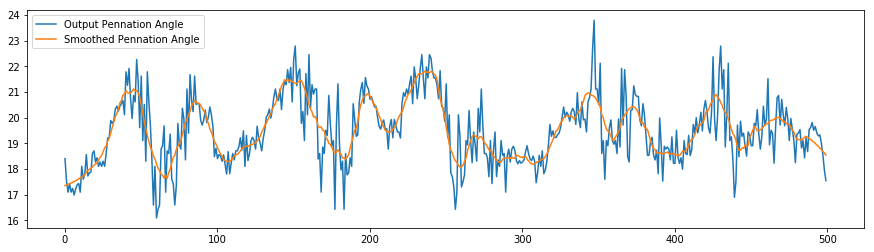

In [103]:
from scipy.signal import savgol_filter
pa_smoothed = savgol_filter(pennation_angle, 27, 2)

pa_x = list(range(pennation_angle.size))
plt.figure(figsize=(15, 4))
plt.plot(pa_x, pennation_angle, label='Output Pennation Angle')
plt.plot(pa_x, pa_smoothed, label='Smoothed Pennation Angle');
plt.legend()

### What's wrong with peaks?

In [104]:
# select 70th image for debug

print('reference angle:', reference_angle[70])
print('pennation angle:', pennation_angle[70])

reference angle: 2.01117318436
pennation angle: 17.5977653631


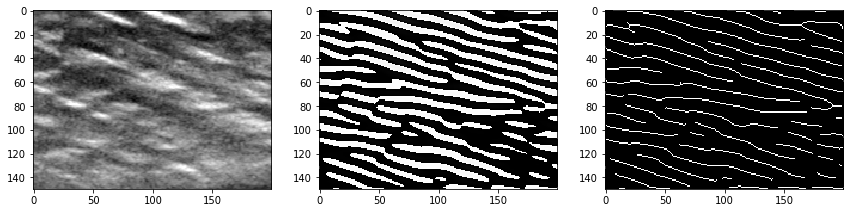

In [105]:
im = images_ROI[70]
filt_real, _ = gabor(im, frequency=0.1, theta=1.8, bandwidth=0.7)
bw = skeletonize(filt_real > 200)

plt.subplot(131); plt.imshow(im)
plt.subplot(132); plt.imshow(filt_real)
plt.subplot(133); plt.imshow(bw)
plt.subplots_adjust(right=2)

### Verification: Performance is sensitive to specific filter **angle**, now increase `theta` to **2.1** (radian).

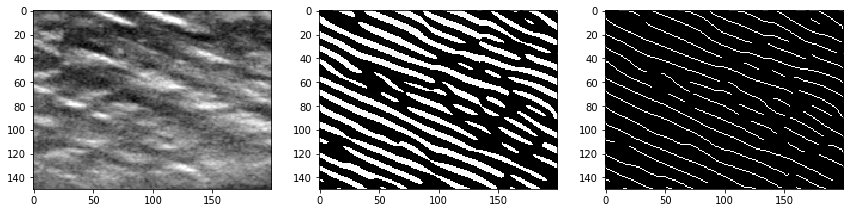

In [106]:
filt_real, _ = gabor(im, frequency=0.1, theta=2.1, bandwidth=0.7)
bw = skeletonize(filt_real > 200)

plt.subplot(131); plt.imshow(im)
plt.subplot(132); plt.imshow(filt_real)
plt.subplot(133); plt.imshow(bw)
plt.subplots_adjust(right=2)

### Recompute pennation angle

In [96]:
# pre-allocate
pennation_angle_2 = np.zeros(images_ROI.shape[0])

In [98]:
for idx, im in tqdm(enumerate(images_ROI)):
    # (1) gabor filter, manually choose parameters
    filt_real, _ = gabor(im, frequency=0.1, theta=2.1, bandwidth=0.7)
    # (2) convert to bw and skeletonize 
    bw = skeletonize(filt_real > 200)
    # (3) hough transform
    _, angles, dists = hough_line_peaks(*hough_line(bw))
    # (4) convert coordinate system, should be negative
    theta = np.rad2deg([-(np.pi/2 + a) if a < 0 else np.pi/2 - a for a in angles])
    # (5) get coarse pennation angle need filter
    diff = reference_angle[idx] - theta
    #  1) keep valid ( > 16) values
    valid = diff[diff > 16]
    #  2) take the mean value if exists
    pennation_angle_2[idx] = np.mean(valid)

500it [03:09,  2.64it/s]


In [99]:
# check NaN and smooth
if any(np.isnan(pennation_angle_2)):
    pennation_angle = fill_nan(pennation_angle_2)
    
pa_smoothed_2 = savgol_filter(pennation_angle_2, 27, 2)

### Compare with `fem.mat`


In [107]:
# load `mat` file
import scipy.io as sio
force, time_x = [sio.loadmat('data/fem.mat')[key].squeeze() for key in ['force', 'time2']]

In [108]:
# load pennation angle using canny filter
pa_canny = np.load('pa_canny.npy')
pa_canny_smoothed = np.load('pa_canny_smoothed.npy')

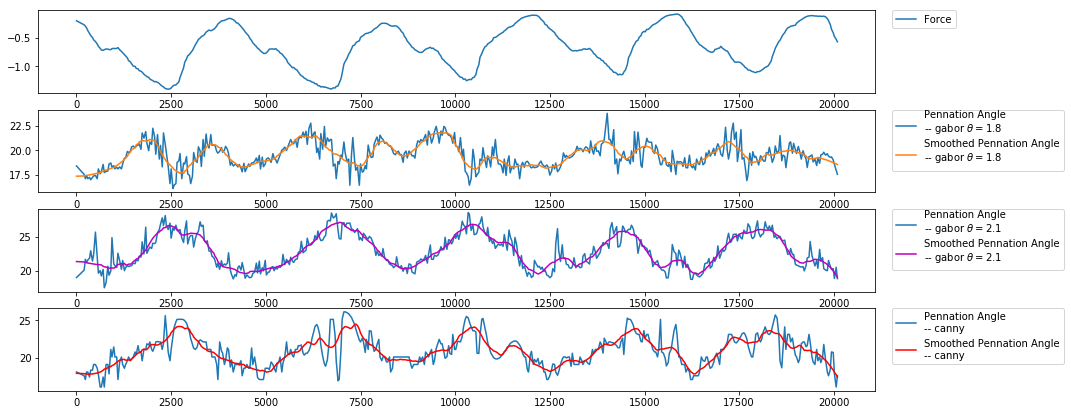

In [123]:
plt.figure(figsize=(15, 7))

plt.subplot(411)
plt.plot(time_x, force, label='Force')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.subplot(412)
plt.plot(time_x, pennation_angle, label='Pennation Angle\n-- gabor $\\theta = 1.8$');
plt.plot(time_x, pa_smoothed, label='Smoothed Pennation Angle\n-- gabor $\\theta = 1.8$');
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.subplot(413)
plt.plot(time_x, pennation_angle_2, label='Pennation Angle\n-- gabor $\\theta = 2.1$');
plt.plot(time_x, pa_smoothed_2, 'm', label='Smoothed Pennation Angle\n-- gabor $\\theta = 2.1$');
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.subplot(414)
plt.plot(time_x, pa_canny, label='Pennation Angle\n-- canny');
plt.plot(time_x, pa_canny_smoothed, 'r', label='Smoothed Pennation Angle\n-- canny');
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.show()

## Discussion

In [115]:
print('standard deviation(canny filter):', np.std(pa_canny - pa_canny_smoothed))
print('standard deviation(gabor filter):', np.std(pennation_angle_2 - pa_smoothed_2))

standard deviation(canny filter): 1.19137130602
standard deviation(gabor filter): 0.956008192178


From the perspective of standard deviation,   
    `gabor` filter **slightly stable** than than `canny` filter, but fails to calculate the peak of pennation angle in middle period.

As the consumed time shown above,    
  
$gabor\ filter\quad time =  03:09\quad 2.64\ images\ /\ sec\quad w.r.t.\ \theta = 1.8$  
$gabor\ filter\quad time =  04:34\quad 1.87\ images\ /\ sec\quad w.r.t.\ \theta = 2.1$  
$canny\ filter\quad time =  00:20\quad 24.0\ images\ /\ sec$

`canny` filter is **14x faster** and **9x faster** than `gabor_1.8` and `gabor_2.1` respectively.

At last, `gabor` filter also needs mannually adjust parameters with patience, whose **hyper-parameters is more** than `canny` filter.

# ResNet

In [20]:
import time
import torch
import torchvision
import torch.utils.data as data_utils

## Prepare dataset

In [21]:
# load images into Tensor
#     train_images.size() == [200, 360, 338]  
#     val_images.size() == [100, 360, 338]
X = np.array([io.imread(pattern.format(i + 1)) for i in range(500)], dtype=np.float32)
X = X[:, np.newaxis, ...]
X_mean, X_std = np.mean(X), np.std(X)
X = torch.FloatTensor((X - X_mean) / X_std)
X_train, X_val = X[: 200], X[200: 300]

In [22]:
# load targets into Tensor
y_train, y_val = [torch.unsqueeze(torch.FloatTensor(np.load('y_' + mode + '.npy')), 1)
                  for mode in ['train', 'val']]

In [23]:
# make iterable loaders
dsets = {mode: data_utils.TensorDataset(eval('X_' + mode), eval('y_' + mode))
         for mode in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_loaders = {mode: data_utils.DataLoader(dsets[mode], batch_size=48, shuffle=True, num_workers=4)
                for mode in ['train', 'val']}

## Display sampled training images and targets

In [24]:
def snapshots(inputs, targets, rows=3, cols=3, step=3):
    
    # compute intervals
    depth = inputs.shape[0]
    begin = depth // 2 - step * (rows * cols // 2)
    
    fig, ax = plt.subplots(rows, cols, figsize=[rows*2, cols*2])
    for i in range(rows * cols):
        idx = begin + i * step
        ax[i // rows, i % rows].set_title('angle %5.2f' % targets[idx, 0])
        ax[i // rows, i % rows].imshow(inputs[idx, 0], cmap='gray')
        ax[i // rows, i % rows].axis('off')
    plt.show()

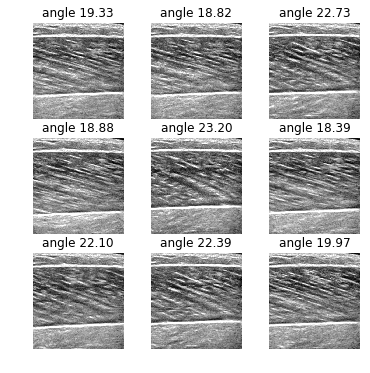

In [25]:
# get a batch of training data
inputs, targets = next(iter(dset_loaders['train']))
# show it
snapshots(inputs.numpy(), targets)

In [26]:
import torch.nn as nn
import torch.optim as optim

from torch.nn import init
from torch.autograd import Variable

In [27]:
# define the learning rate scheduler

def exp_lr_scheduler(optimizer, epoch, init_lr=1e-4, lr_decay_epoch=20):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

#     if epoch % lr_decay_epoch == 0:
#         print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [28]:
def train(model, num_epochs=100):

    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    num_bottleneck = model.fc.in_features
    model.fc = nn.Linear(num_bottleneck, 1) 
    
    criterion = nn.MSELoss()
    
    ignored_params = list(map(id, model.fc.parameters()))
    base_params = filter(lambda p: id(p) not in ignored_params,
                         model.parameters())
    
    lr_scheduler = exp_lr_scheduler
    
    optimizer = optim.SGD([
                {'params': base_params},
                {'params': model.fc.parameters(), 'lr': 1e-5}
                ], lr=1e-4, momentum=0.9)
    

    # Parallel training on GPUs
    model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3]).cuda()

    epoch_loss = {'train': [], 'val': []}
    
    for epoch in tqdm(range(num_epochs)):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            for data in dset_loaders[phase]:
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]

            # record epoch_loss
            epoch_loss[phase] += [running_loss / dset_sizes[phase]]

    return model, epoch_loss

## Train the model ResNet-152

In [29]:
model_152, loss_152 = train(torchvision.models.resnet152(pretrained=True))

100%|██████████| 100/100 [07:45<00:00,  4.54s/it]


## Train the model ResNet-18

In [30]:
model_18, loss_18 = train(torchvision.models.resnet18(pretrained=True))

100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


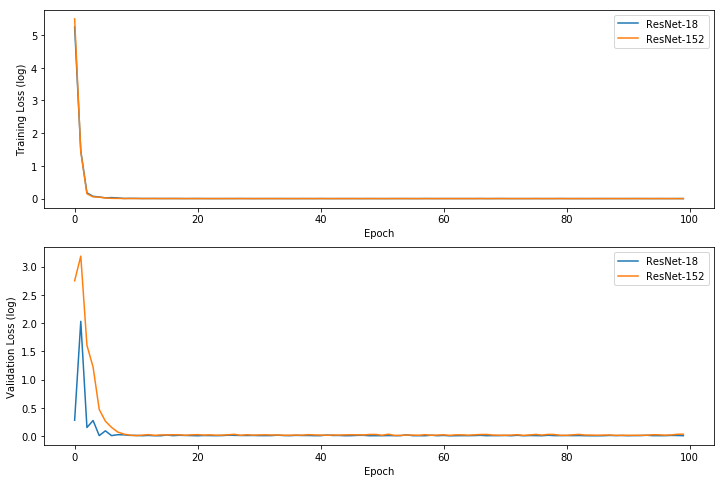

In [31]:
# compare the loss
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(loss_18['train'], label='ResNet-18')
plt.plot(loss_152['train'], label='ResNet-152')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (log)')
plt.legend()

plt.subplot(212)
plt.plot(loss_18['val'], label='ResNet-18')
plt.plot(loss_152['val'], label='ResNet-152')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (log)')
plt.legend()

## Inference

In [32]:
res_18 = np.zeros([500, 1])
res_152 = np.zeros([500, 1])

for i in tqdm(range(500)):
    image = Variable(X[i], volatile=True).cuda().unsqueeze(0)
    res = model_18(image)
    res_18[i] = res.data.cpu().numpy()[0][0]
    res = model_152(image)
    res_152[i] = res.data.cpu().numpy()[0][0]

100%|██████████| 500/500 [00:25<00:00, 19.29it/s]


In [33]:
# smooth curve
res_18_smoothed = savgol_filter(res_18.squeeze(), 27, 2)
res_152_smoothed = savgol_filter(res_152.squeeze(), 27, 2)

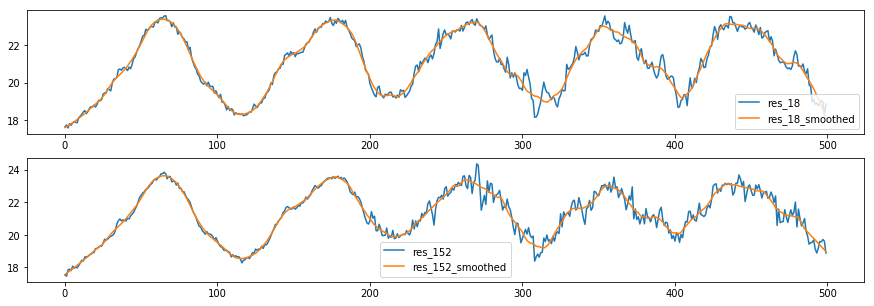

In [34]:
plt.figure(figsize=(15, 5))
plt.subplot(211)
plt.plot(pa_x, res_18, label='res_18');
plt.plot(pa_x, res_18_smoothed, label='res_18_smoothed');
plt.legend()

plt.subplot(212)
plt.plot(pa_x, res_152, label='res_152');
plt.plot(pa_x, res_152_smoothed, label='res_152_smoothed');
plt.legend()

### Compare with `fem.mat`

In [117]:
import scipy.io as sio

force, time_x = [sio.loadmat('data/fem.mat')[key].squeeze() for key in ['force', 'time2']]

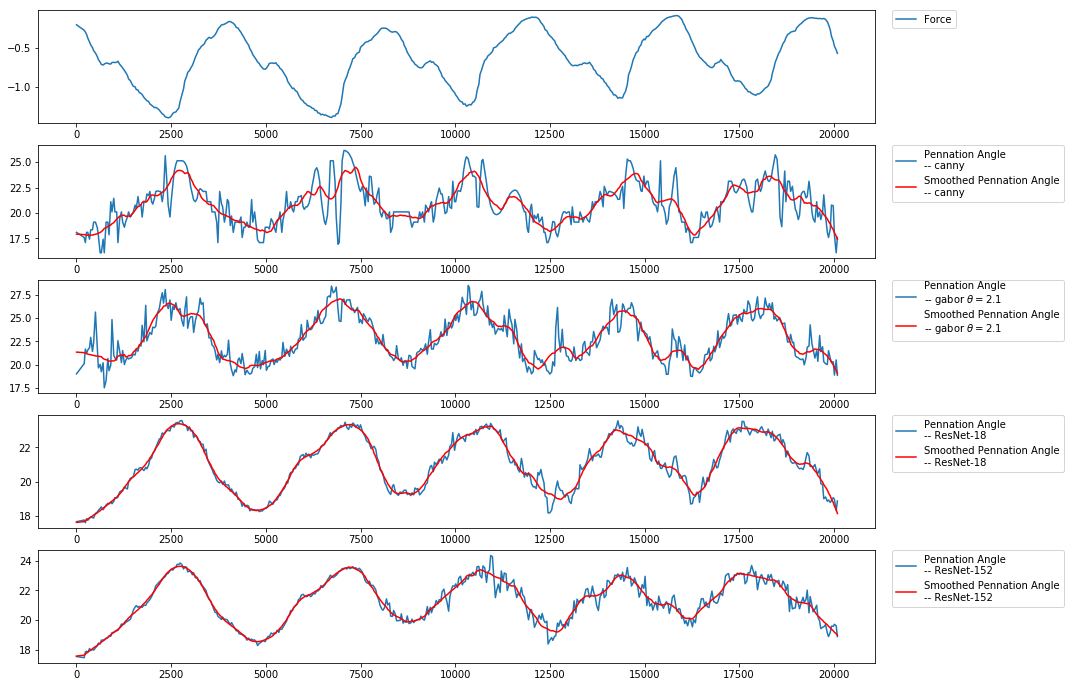

In [122]:
plt.figure(figsize=(15, 12))

plt.subplot(511)
plt.plot(time_x, force, label='Force')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.subplot(512)
plt.plot(time_x, pa_canny, label='Pennation Angle\n-- canny');
plt.plot(time_x, pa_canny_smoothed, 'r', label='Smoothed Pennation Angle\n-- canny');
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.subplot(513)
plt.plot(time_x, pennation_angle_2, label='Pennation Angle\n-- gabor $\\theta = 2.1$');
plt.plot(time_x, pa_smoothed_2, 'r', label='Smoothed Pennation Angle\n-- gabor $\\theta = 2.1$');
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.subplot(514)
plt.plot(time_x, res_18, label='Pennation Angle\n-- ResNet-18');
plt.plot(time_x, res_18_smoothed, 'r', label='Smoothed Pennation Angle\n-- ResNet-18');
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.subplot(515)
plt.plot(time_x, res_152, label='Pennation Angle\n-- ResNet-152');
plt.plot(time_x, res_152_smoothed, 'r', label='Smoothed Pennation Angle\n-- ResNet-152');
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.show()

## Discussion

1. Performance `ResNet-152` > `ResNet-18` > `gabor_2.1` > `canny`.
1. Both `gabor` filter and `canny` filter need carefully tune the parameters, while `ResNet` could automatically learn the weights.
2. The training labels (pennation angle) is not measured precisely, this part may be improved in the further. Similarly, training images could do some data augment.
3. Considering the weights learned by neural network, it's very likely that kernels contain `gabor` and `canny` filter.

## Supplement: Visualize Neural Network Filters

In [60]:
def plot_filters(filters, num_cols=8):
    nums = filters.shape[0]
    num_rows = 1+ nums // num_cols
    fig = plt.figure(figsize=(num_cols, num_rows))
    for i in range(filters.shape[0]):
        ax1 = fig.add_subplot(num_rows, num_cols, i + 1)
        ax1.imshow(filters[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

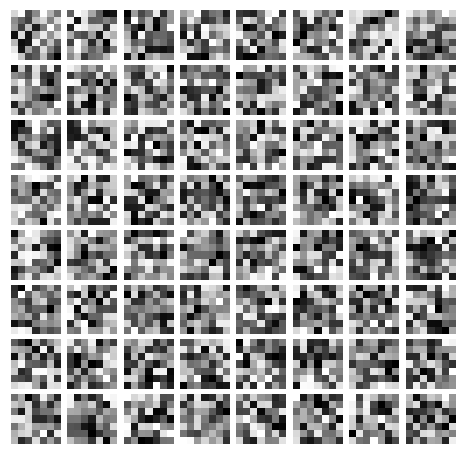

In [62]:
conv1_filter_152 = model_152.state_dict()['module.conv1.weight'].cpu().numpy().squeeze()
plot_filters(conv1_filter_152)

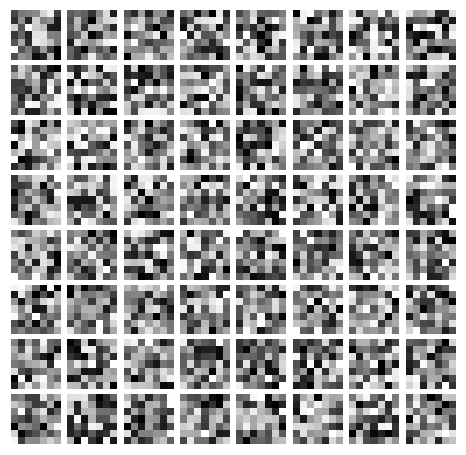

In [63]:
conv1_filter_18 = model_18.state_dict()['module.conv1.weight'].cpu().numpy().squeeze()
plot_filters(conv1_filter_18)

## Discussion

Above `conv1` filters are not able to show direct similarity with `gabor` or `guassian` filters probably because `ResNet` has too many resudial connections. However, `AlexNet` could demonstrate some correlation.

### conv_1 filters
![](http://cs231n.github.io/assets/cnnvis/filt1.jpeg "conv1 filters in AlexNet")

### conv_2 filters
![](http://cs231n.github.io/assets/cnnvis/filt2.jpeg "conv2 filters in AlexNet")